# Example: Quantum Convolutional Neural Network

In this notebook we show how to use the `QCNN encoding circuit` for regression and classification.

## Imports

In [1]:
import numpy as np
from qiskit.circuit import QuantumCircuit
from qiskit.circuit import ParameterVector
from squlearn.encoding_circuit import (
    QiskitEncodingCircuit,
    QCNNEncodingCircuit,
    LayeredEncodingCircuit,
)
from squlearn.qnn import QNNClassifier, QNNRegressor, SquaredLoss
from squlearn.optimizers import Adam
from squlearn import Executor
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from squlearn.observables import CustomObservable
from sklearn.datasets import make_moons

## `QCNN encoding circuit` Setup

We start by showing examples of how to build the QCNN. The first example is the most simple way. With the `default` keyword set to "True" the default circuit with the given number of qubits and features is build.

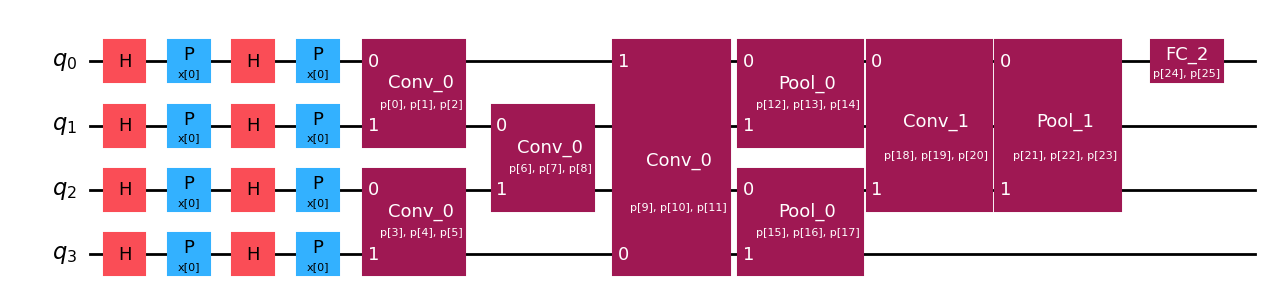

In [2]:
qc = QCNNEncodingCircuit(num_qubits=4, default=True)
qc.draw("mpl", num_features=1)

Another fast way would be to define a convolution layer and a pooling layer and call the `repeat_layers` function to repeat the first layers until few enough qubits are left in the circuit. The individual building blocks can be resolved with the keyword `decompose`. As one can see, with the keyword `measurement` set to True in the pooling layer one can implement gates on qubits conditioned on the outcome of a measurement on another qubit instead of normal conditional (e.g. cx) gates.

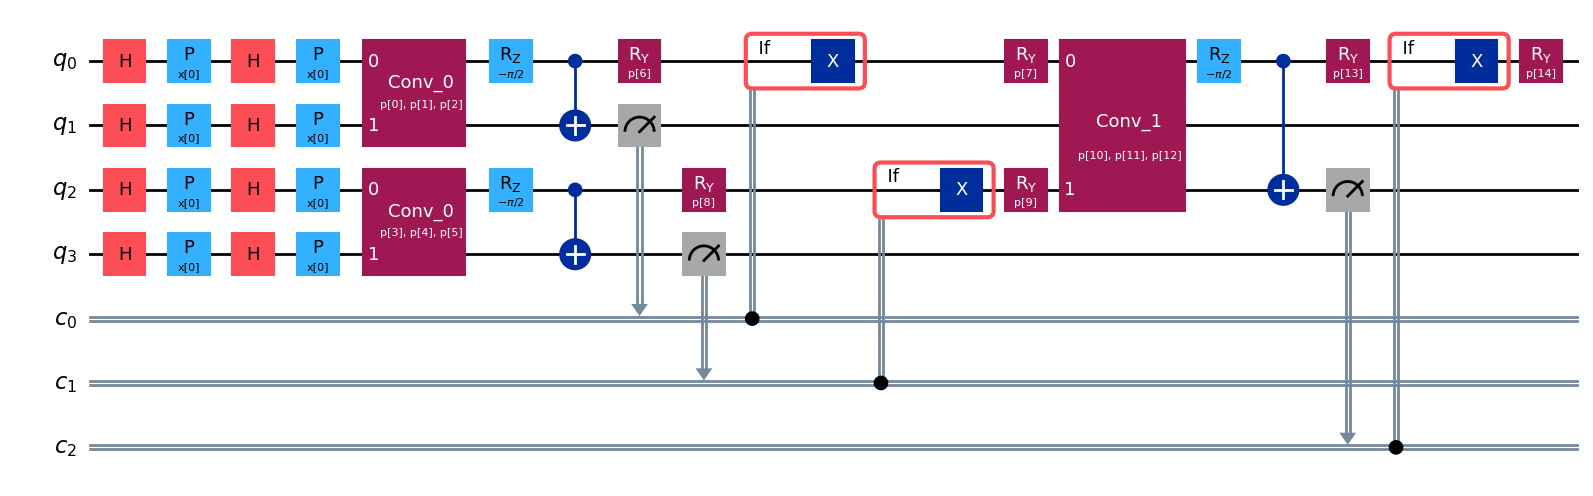

In [3]:
qc = QCNNEncodingCircuit(4)
qc.convolution(alternating=False)
qc.pooling(measurement=True)
qc.repeat_layers()
qc.draw("mpl", num_features=1, cregbundle=False)

We can provide our own feature map and add it in front of the encoding circuit. Further we can change the number of qubits and features in the circuit on the fly `up` (and `down`, if the already applied pooling gates allow it).

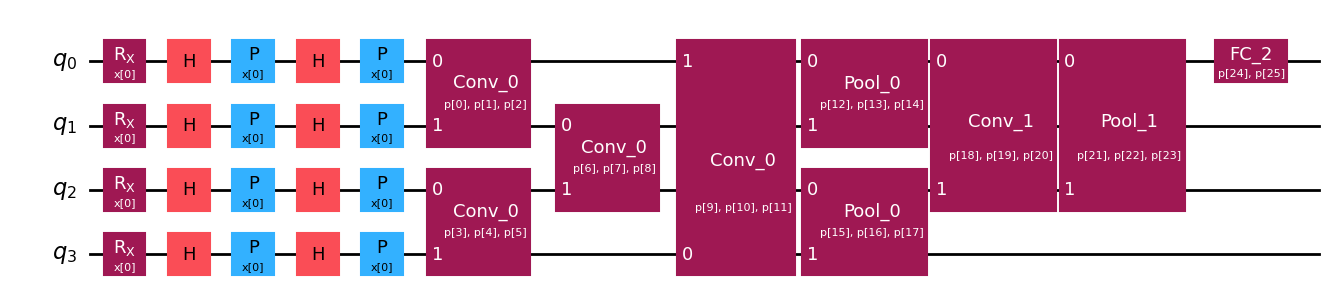

In [4]:
qc = QCNNEncodingCircuit(num_qubits=3, default=True)
qc.set_params(num_qubits=4)
encode = LayeredEncodingCircuit.from_string("Rx(x)", num_qubits=4)
qcnn = encode + qc
qcnn.draw("mpl", num_features=1)

We can overwrite the default circuits in the given layer by setting the keyword `quantum_circuit`. The Circuits can either be `QuantumCircuit` or `sQUlearn circuit` objects (if one inputs a circuit with features an Error is raised). Notice that the qiskit `ParameterVector`'s are overwritten with the internal parameters. The circuit size is only restricted by the number of qubits left in the qcnn. In the pooling layer the adressed qubits can be set with the keywords `input_list` and `output_list`.

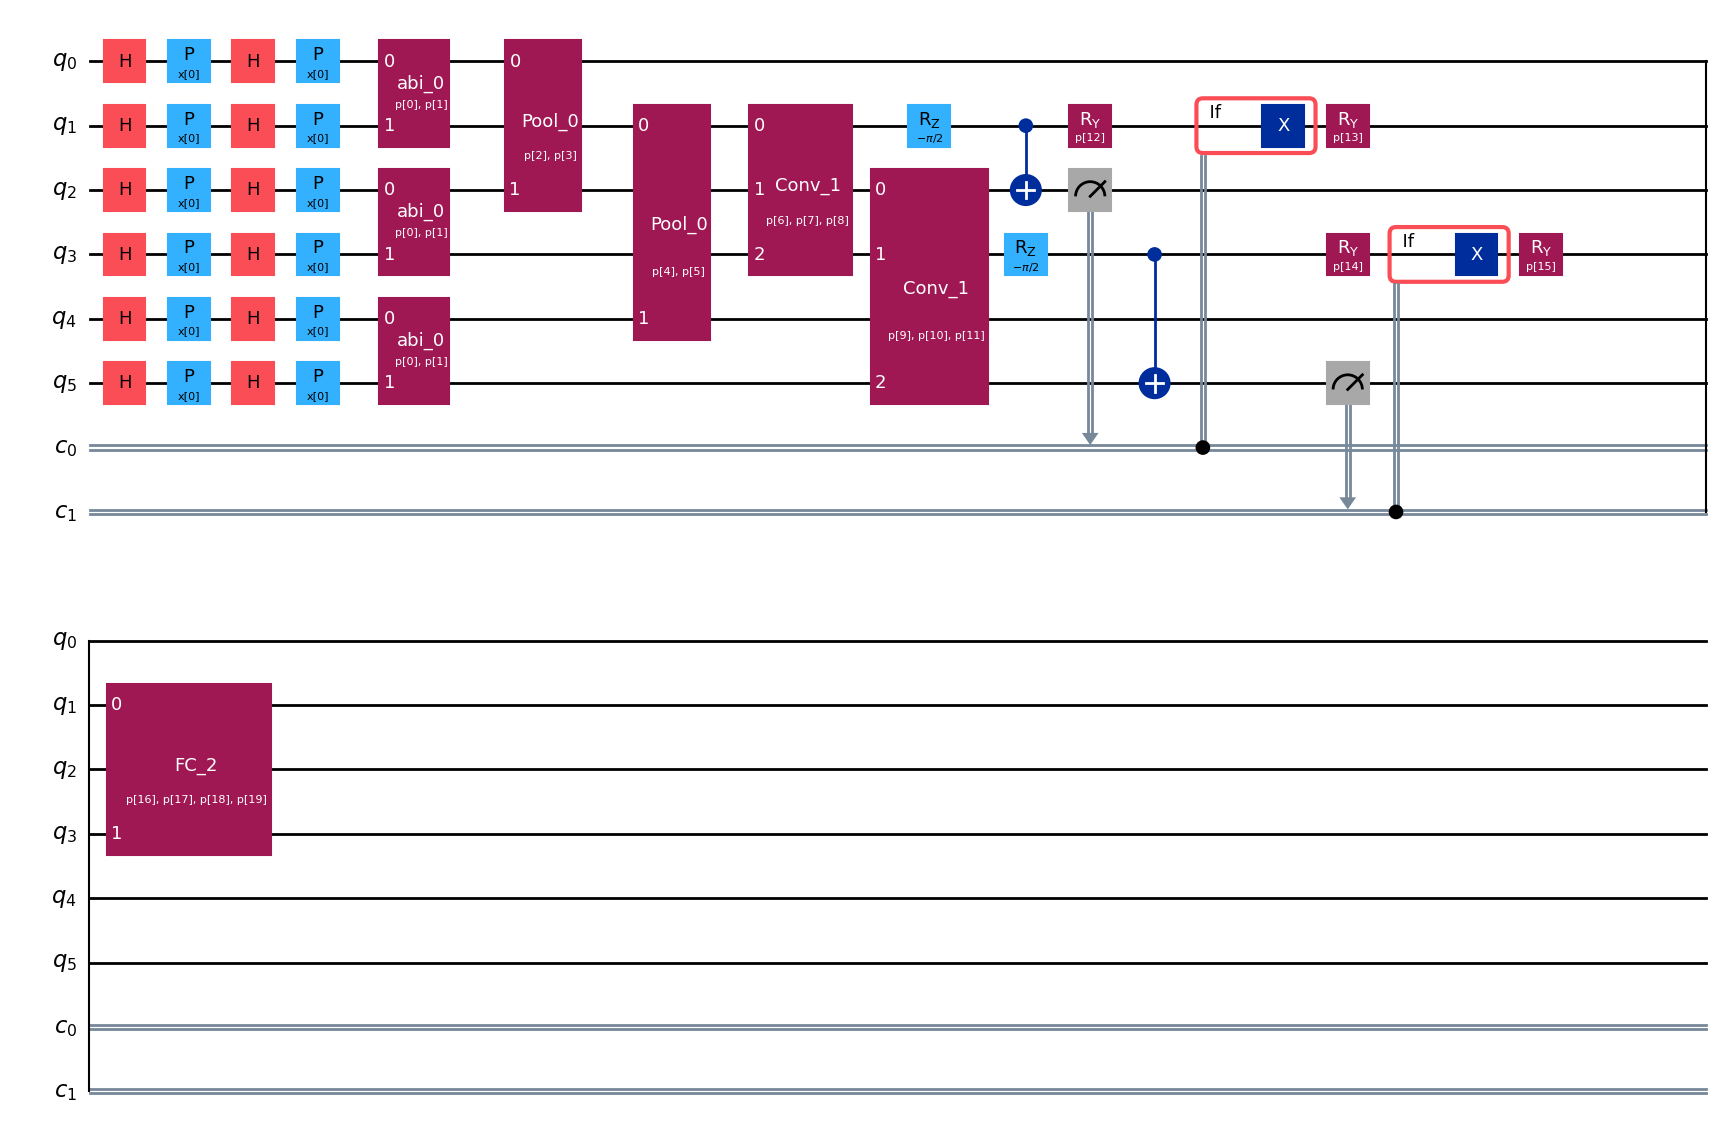

In [5]:
qc = QCNNEncodingCircuit(6)

x1 = ParameterVector("p", 2)
qc1 = QuantumCircuit(2)
qc1.crx(x1[0], 0, 1)
qc1.rx(x1[1], 0)

qc2 = QiskitEncodingCircuit(qc1)  # sQUlearn circuit object

x31 = ParameterVector("v", 2)
x32 = ParameterVector("l", 1)
qc3 = QuantumCircuit(3)
qc3.rx(x31[0], 0)
qc3.rx(x31[1], 1)
qc3.rx(x32[0], 2)
qc3.cx(0, 1)
qc3.cx(1, 2)

qc.convolution(quantum_circuit=qc1, label="abi", alternating=False, share_params=True)
qc.pooling(quantum_circuit=qc2, input_list=[[0, 2], [1, 4]], output_list=[[2], [1]])
qc.convolution(quantum_circuit=qc3)
qc.pooling(measurement=True)
qc.fully_connected()
qc.draw("mpl", num_features=1, cregbundle=False)

Finally we can build the circuit "backwards" by supplying the gates first and then how many qubits should be in the output and you can even continue building from there forward if no fully connected layer is applied. Be careful with adressing the correct qubits when providing in- and output lists.

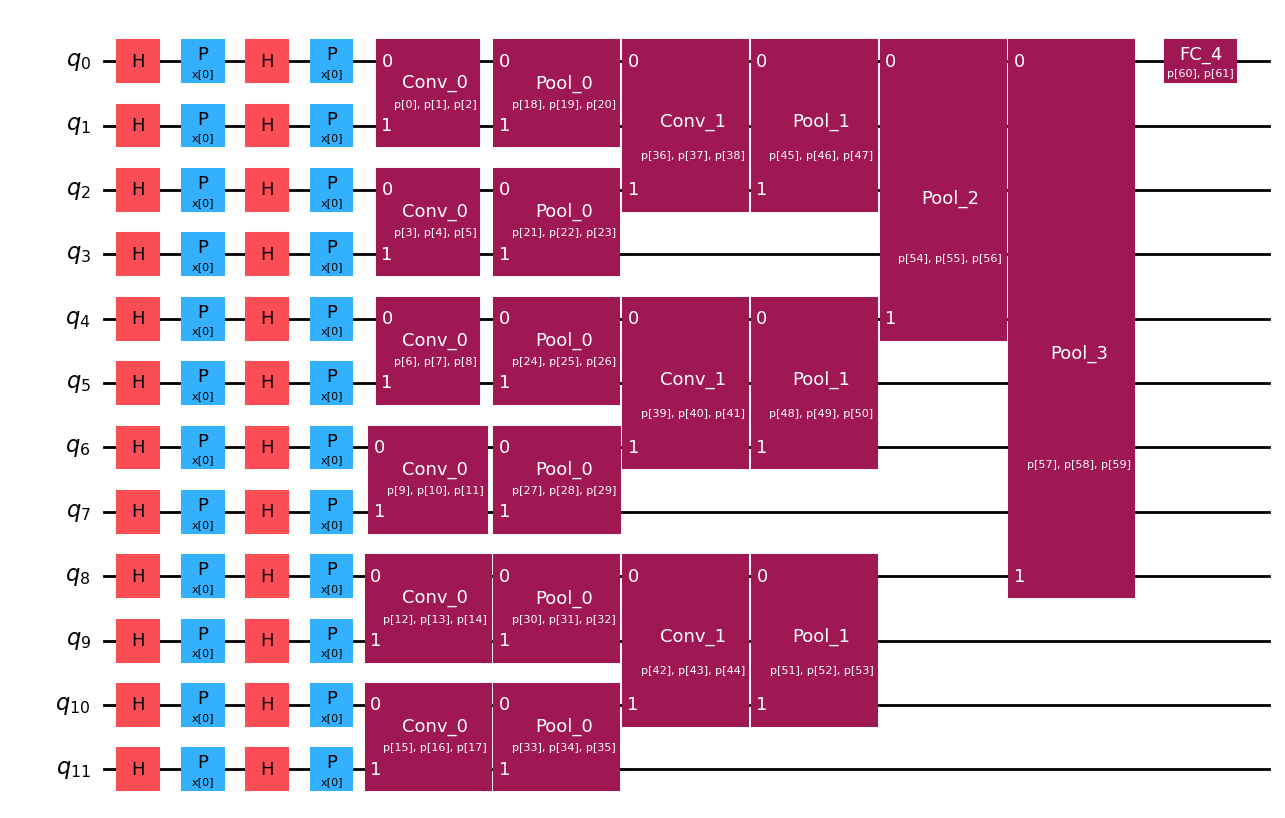

In [6]:
# build backwards
qc = QCNNEncodingCircuit()
qc.convolution(alternating=False)
qc.pooling()
qc.repeat_layers(1)
qc.pooling(input_list=[[0, 4]], output_list=[[0]])
qc.build_circuit(2)
# continue forwards
qc.pooling()
qc.fully_connected()
qc.draw("mpl", num_features=1)

The fitting default observable for the circuit can be extracted once finished with building the circuit. Notice that the observable "IIIIIZ" corresponds to only measuring the first qubit "q0".

In [7]:
obs = qc.QCNNObservable(obs="X")
print(obs)

SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIX'],
              coeffs=[<qiskit._accelerate.circuit.ParameterExpression object at 0x000001A5A6C7AE50>,
 <qiskit._accelerate.circuit.ParameterExpression object at 0x000001A5A6CE8450>])


Alternatively one can provide an Observable for the left qubits which then is mapped onto all qubits.

In [8]:
qc = QCNNEncodingCircuit(4)
qc.convolution()
qc.pooling()
qc.fully_connected()
obs = CustomObservable(2, ["XY", "ZZ", "ZI", "IY"])
qc.QCNNObservable(obs)

SparsePauliOp(['IXIY', 'IZIZ', 'IZII', 'IIIY'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])

In the following we creat training and test data for a very simple regression problem. This example is supposed to show how to properly work with this encoding circuit in the sQUlearn environment.

In [9]:
# Data that is inputted to the QNN
X = np.arange(-0.5, 0.6, 0.1).reshape(-1, 1)
# Data that is fitted by the QNN
y = np.square(X).ravel()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=44)

Next the encoding circuit and observable are build.

SparsePauliOp(['IIII', 'IIIZ'],
              coeffs=[<qiskit._accelerate.circuit.ParameterExpression object at 0x000001A5A7394BD0>,
 <qiskit._accelerate.circuit.ParameterExpression object at 0x000001A5A7395290>])


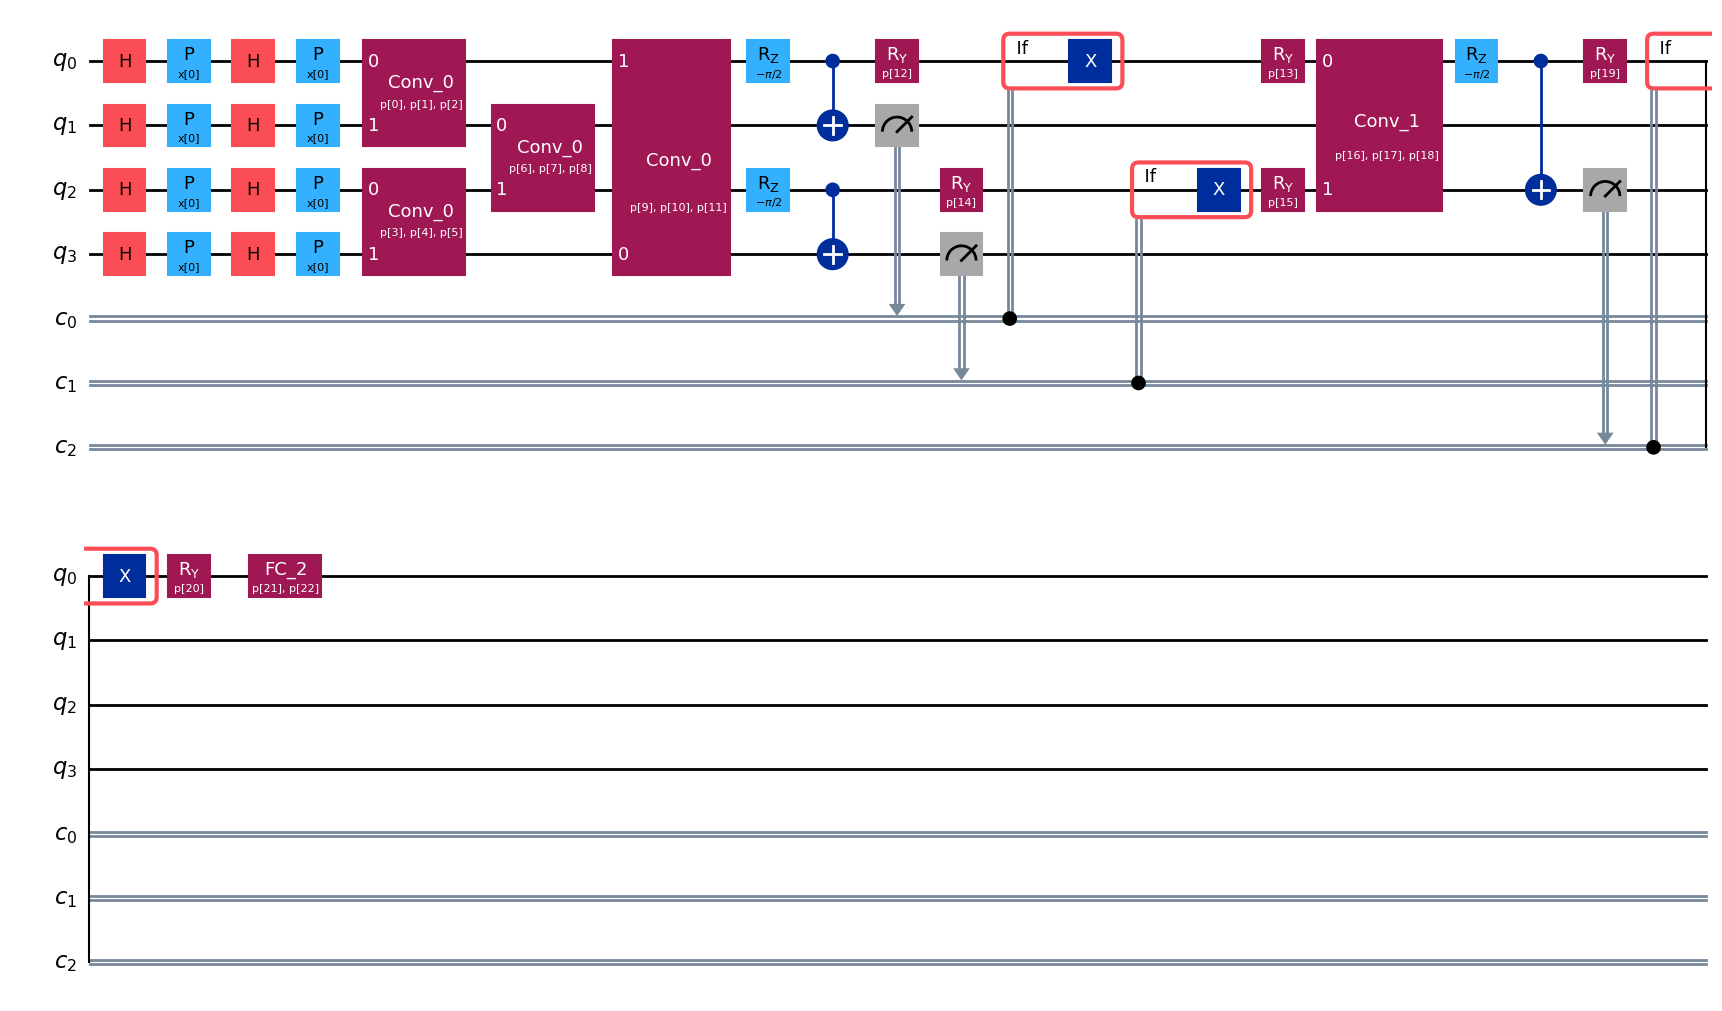

In [10]:
qc = QCNNEncodingCircuit(4)
qc.convolution()
qc.pooling(measurement=True)
qc.repeat_layers()
qc.fully_connected()

obs = qc.QCNNObservable()
print(obs)
qc.draw("mpl", num_features=1, cregbundle=False)

Now we can set up the Regressor and train it.

In [11]:
qnn = QNNRegressor(
    qc,
    obs,
    Executor("pennylane"),
    SquaredLoss(),
    Adam(options={}),
)
qnn.fit(X_train, y_train)

fit: 100%|██████████| 100/100 [00:19<00:00,  5.00it/s]


Finally we can plot the results of the regression.

Optimal gate parameters:
[
0.4712786451165339,
1.8223687335667682,
1.1469096011825084,
1.2084023750744395,
-1.1895578105125704,
0.10646472622947517,
0.09017037881395831,
2.8291185468446782,
2.445833121929585,
-0.10091606725177121,
2.2619647023465275,
-0.3331750592350766,
0.059244901802205034,
3.1706833999306867,
-2.312810954367976,
-2.10492639675496,
-3.014556715852012,
2.555888710260058,
1.4131189443776302,
2.7908314771792795,
2.6726562693802727,
1.4087038201208752,
0.2924174744518168,
]
--------------
Optimal observable parameters:
[
0.5485768872109295,
1.2370231217847583,
]
sigma train:  0.013229971339838902 , sigma test:  0.02182212850473732


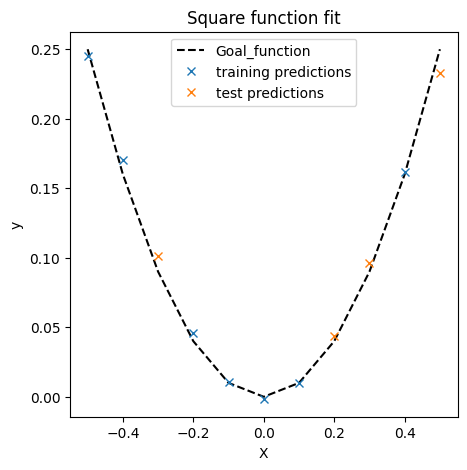

In [12]:
# ouput optimal parameters
print("Optimal gate parameters:")
print("[")
for i in qnn.param:
    print(str(i) + ",")
print("]")
print("--------------")
print("Optimal observable parameters:")
print("[")
for i in qnn.param_op:
    print(str(i) + ",")
print("]")

y_train_predict = qnn.predict(X_train)
y_test_predict = qnn.predict(X_test)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.set_title("Square function fit")
ax.plot(X, y, label="Goal_function", linestyle="dashed", color="black")
ax.plot(X_train, y_train_predict, label="training predictions", marker="x", linestyle="None")
ax.plot(X_test, y_test_predict, label="test predictions", marker="x", linestyle="None")
ax.set(xlabel="X", ylabel="y")
ax.legend()

sigma_train = np.sqrt(np.sum(np.square(y_train_predict - y_train)))
sigma_test = np.sqrt(np.sum(np.square(y_test_predict - y_test)))
print("sigma train: ", sigma_train, ", sigma test: ", sigma_test)

In the following a classification example is shown. Firstly, data is generated from the sklearn `make_moons` dataset.

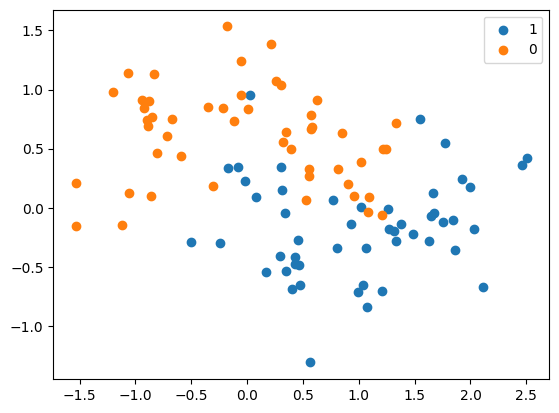

In [13]:
X, y = make_moons(noise=0.3, random_state=1, n_samples=100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=0)

plt.scatter(
    [X[i][0] for i in range(len(y)) if y[i] == 1],
    [X[i][1] for i in range(len(y)) if y[i] == 1],
    label="1",
)
plt.scatter(
    [X[i][0] for i in range(len(y)) if y[i] == 0],
    [X[i][1] for i in range(len(y)) if y[i] == 0],
    label="0",
)
plt.legend()
plt.show()

Then we instantiate the QCNN encoding circuit, the Observable and the Classifier.

SparsePauliOp(['IIII', 'IIIZ'],
              coeffs=[<qiskit._accelerate.circuit.ParameterExpression object at 0x000001A5A7BBEA30>,
 <qiskit._accelerate.circuit.ParameterExpression object at 0x000001A5A7CAEE50>])


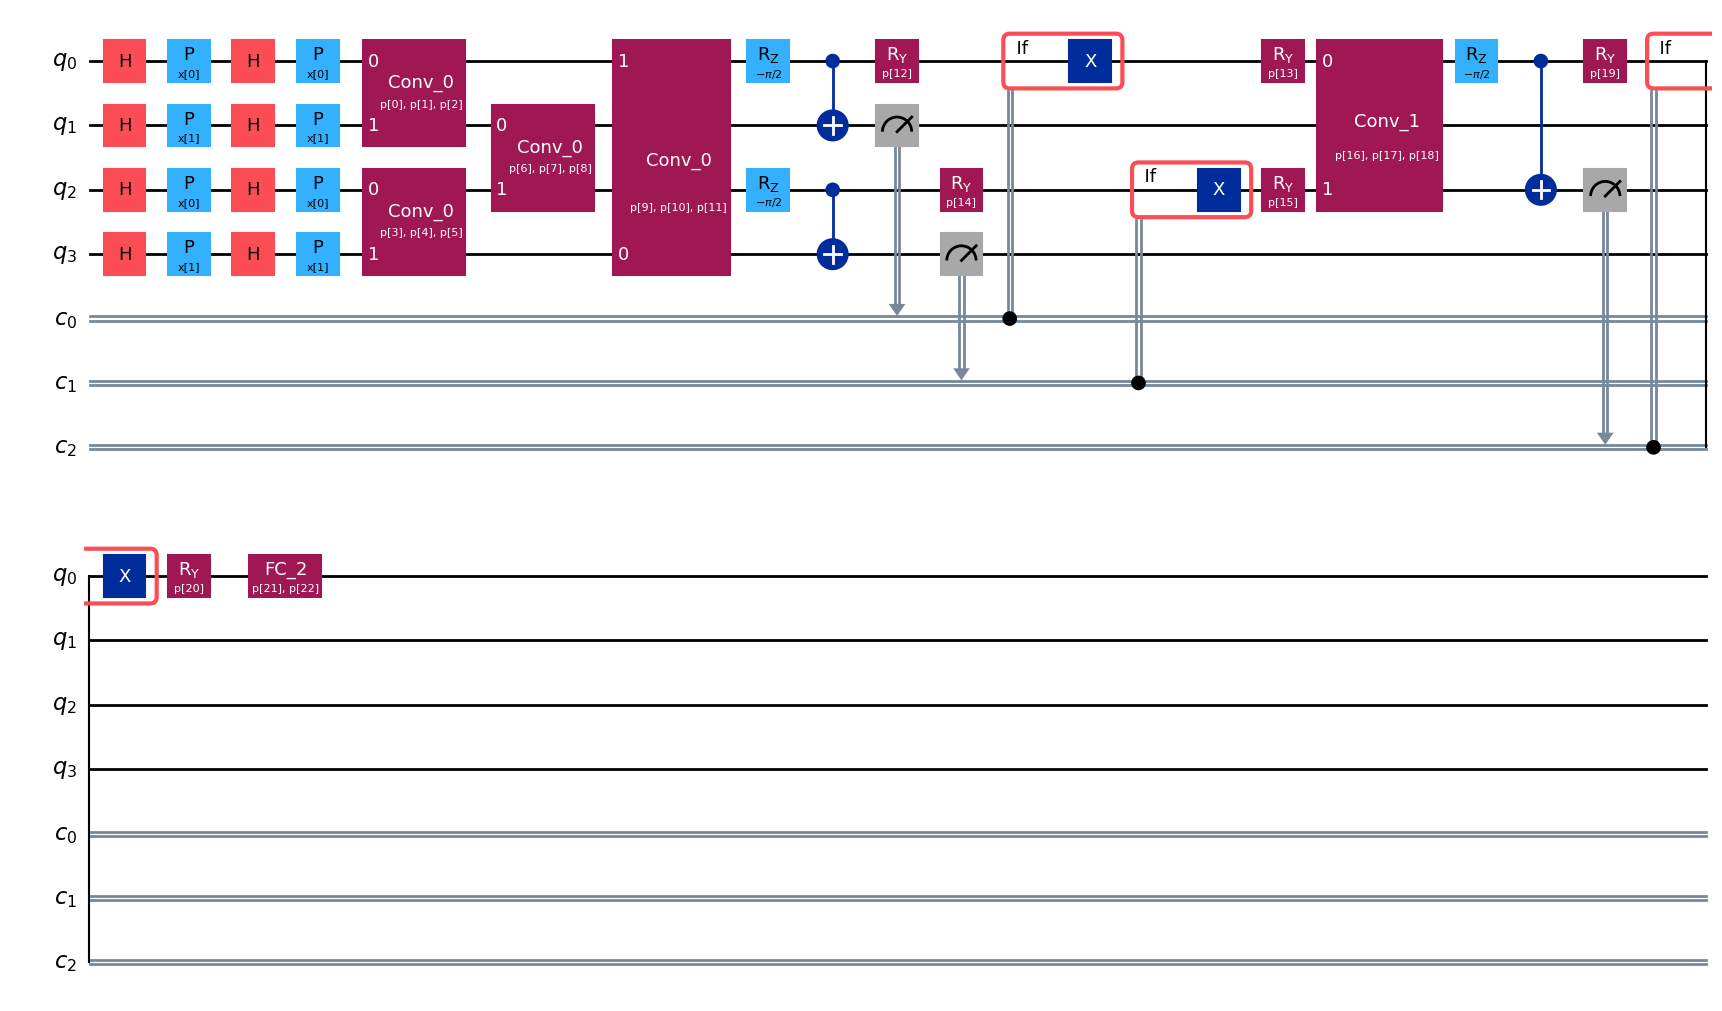

In [14]:
qc = QCNNEncodingCircuit(4)
qc.convolution()
qc.pooling(measurement=True)
qc.repeat_layers()
qc.fully_connected()

obs = qc.QCNNObservable()

qnn = QNNClassifier(qc, obs, Executor(), SquaredLoss(), Adam())
print(obs)
qc.draw("mpl", num_features=2, cregbundle=False)

Finally we train and predict the model.

In [15]:
# Train the model
qnn.fit(X_train, y_train)

# Data for testing the trained model
print("Training score:", qnn.score(X_train, y_train))
print("Testing score:", qnn.score(X_test, y_test))

fit: 100%|██████████| 100/100 [00:51<00:00,  1.93it/s]
Training score: 0.9
Testing score: 0.8428571428571429


The decission surface of the QCNN for the two moons problem is shown.

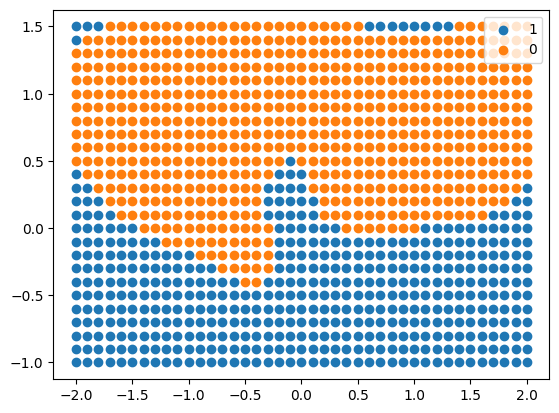

In [16]:
X_new = []
for i in range(-20, 21):
    for j in range(-10, 16):
        X_new.append([i / 10, j / 10])
y_pred = qnn.predict(X_new)
plt.scatter(
    [X_new[i][0] for i in range(len(y_pred)) if y_pred[i] == 1],
    [X_new[i][1] for i in range(len(y_pred)) if y_pred[i] == 1],
    label="1",
)
plt.scatter(
    [X_new[i][0] for i in range(len(y_pred)) if y_pred[i] == 0],
    [X_new[i][1] for i in range(len(y_pred)) if y_pred[i] == 0],
    label="0",
)
plt.legend()
plt.show()